# Классификация ответов

Изучим применение косинусного расстояния для классификации ответов по профессиям. 

У нас есть данные с признаками ответов, позволяющие выделить не относящиеся к профессиям. Есть нормализованные токены. И есть справочник профессий, также содержащий нормализованные токены.

- Выделим ответы, относящиеся только к профессиям;
- Загрузим справочник профессий;
- Оценим, какое количество профессий можно классфицировать сравнением строк нормализовнных токенов;
- Для профессий, которые не получилось классифицировать сравнением, применим поиск подходящей профессии по косинусному сходству:
    - преобразуем все нормализованные профессии из справоничка в вектора;
    - для каждого нормализованного ответа найдм профессию с максимальным сходством;
    - проанализируем результаты.

## Загрузка библиотек

In [167]:
import pandas as pd
import numpy as np

In [168]:
from gensim.models import fasttext

In [169]:
from sklearn.metrics.pairwise import cosine_similarity

In [170]:
from tqdm import tqdm

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Функции

In [172]:
def sentence_2_vec(model: fasttext.FastTextKeyedVectors, sentence: list) -> np.array:
    '''Преобразует предложение как массив слов в вектор как сумму векторов каждого слова
    '''
    vectors = [model.get_vector(word) for word in sentence]

    return np.sum(vectors, axis=0)

## Загрузка данных

In [173]:
answers = pd.read_csv('../datasets/intermediate/df_answers_analysed.csv', low_memory=False)
professions = pd.read_csv('../datasets/external/tokens-professions.csv')

In [174]:
answers.shape

(149700, 142)

In [175]:
professions.shape

(194, 2)

Выделим из ответов только относящиеся к профессиям и признаки, содержащие ответ и его признаки.

In [176]:
columns = ['q61', 'corrected', 'tokenized', 'normalized']

In [177]:
answers = answers.loc[
    ~answers.normalized.isna()\
    & (answers.n_verbs == 0)\
    & (answers.has_negative == 0)\
    & (answers.has_past_future == 0)\
    & (answers.n_out_of_vocab < 4), 
    columns]

In [178]:
answers.shape

(79548, 4)

In [179]:
answers.head()

,q61,corrected,tokenized,normalized
0,экономист,экономист,экономист,экономист
2,Учитель,учитель,учитель,учитель
6,рекламист,рекламы,рекламы,реклама
7,Руководитель участка,руководитель участка,руководитель участка,руководитель
11,Повар,повар,повар,повар


In [180]:
professions.head()

,prof_tokens,prof_names
0,автомойщик,автомойщик
1,автослесарь,автослесарь
2,автомеханик,автомеханик
3,мастер-приёмщик,мастер-приемщик
4,продажа,менеджер по продажам


## Прямое сравнение

In [181]:
answers['score'] = 0
answers['matched_token'] = None

In [182]:
prof_keys = professions.prof_tokens.to_list()
answers['direct_match'] = answers.apply(lambda row: 1 if row.normalized in prof_keys else 0, axis=1)

In [183]:
answers.direct_match.value_counts()

0    45747
1    33801
Name: direct_match, dtype: int64

In [184]:
answers[answers.direct_match == 1].head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match
0,экономист,экономист,экономист,экономист,0,None,1
2,Учитель,учитель,учитель,учитель,0,None,1
11,Повар,повар,повар,повар,0,None,1
17,Видеооператор,видеооператор,видеооператор,видеооператор,0,None,1
18,преподаватель,преподаватель,преподаватель,преподаватель,0,None,1


In [185]:
answers[answers.direct_match == 0].head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match
6,рекламист,рекламы,рекламы,реклама,0,None,0
7,Руководитель участка,руководитель участка,руководитель участка,руководитель,0,None,0
12,Фитнес,фитнес,фитнес,фитнес,0,None,0
15,Менеджер регионального отдела продаж,менеджер регионального отдела продаж,менеджер регионального отдела продаж,продажа региональный,0,None,0
16,инженер,инженер,инженер,инженер,0,None,0


In [186]:
answers.loc[answers.direct_match == 1, 'score'] = 1
answers.loc[answers.direct_match == 1, 'matched_token'] = answers.loc[answers.direct_match == 1, 'normalized'] 

## Сопоставление по косинусному сходству

Загрузим модель для векторизации токенов.

In [187]:
cc_ru_path = '../models/cc_ru_300_kv/cc_ru_300.kv'
model = fasttext.FastTextKeyedVectors.load(cc_ru_path)

Получим вектора для токенов профессий.

In [188]:
v_professions = []
for prof in prof_keys:
    words = prof.split()
    v = sentence_2_vec(model=model, sentence=words)
    v_professions.append(v)

In [189]:
unmatched = answers[answers.direct_match == 0]
unmatched.shape

(45747, 7)

In [190]:
def find_similar(what: np.array, where: list) -> tuple:
    '''Ищет вектор в where с максимальным косинусным сходством с what 
    '''
    matrix = pd.DataFrame(cosine_similarity([what], where)).T
    idx = matrix.idxmax()
    score = matrix.max().item()

    return idx, score

In [191]:
for i, row in tqdm(unmatched.iterrows(), total=unmatched.shape[0]):
    v = sentence_2_vec(model=model, sentence=row.normalized.split())
    idx, score = find_similar(what=v, where=v_professions)
    matched_token = professions.prof_tokens[idx].item()
    answers.loc[i, 'score'] = score
    answers.loc[i, 'matched_token'] = matched_token

100%|██████████| 45747/45747 [04:57<00:00, 153.94it/s]


In [192]:
columns = columns + ['direct_match', 'score', 'matched_token']

In [193]:
answers[answers.direct_match == 1][columns].sample(10)

,q61,corrected,tokenized,normalized,direct_match,score,matched_token
36168,Водитель,водитель,водитель,водитель,1,1.0,водитель
68801,Экономист,экономист,экономист,экономист,1,1.0,экономист
120716,Энергетик,энергетик,энергетик,энергетик,1,1.0,энергетик
127269,экономист,экономист,экономист,экономист,1,1.0,экономист
131229,учитель,учитель,учитель,учитель,1,1.0,учитель
80317,мерчендайзер,мерчандайзер,мерчандайзер,мерчандайзер,1,1.0,мерчандайзер
8259,Механик,механик,механик,механик,1,1.0,механик
30909,Официант,официант,официант,официант,1,1.0,официант
102497,Официант,официант,официант,официант,1,1.0,официант
136397,Специалисты | Дизайнер,дизайнер,дизайнер,дизайнер,1,1.0,дизайнер


<AxesSubplot:>

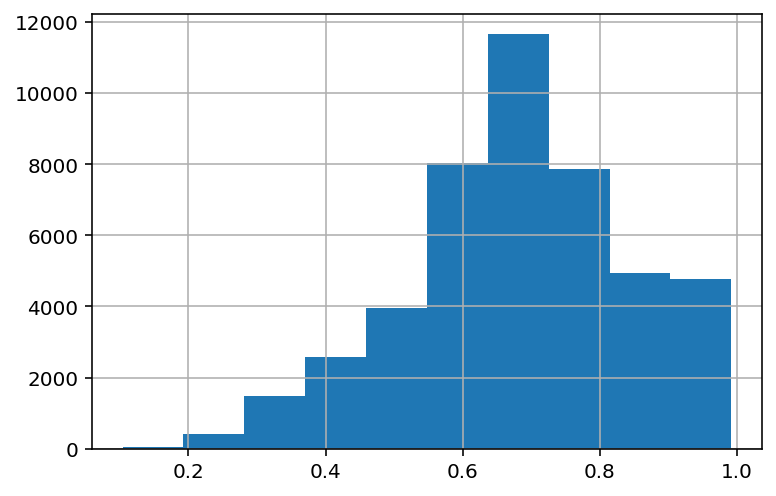

In [194]:
answers[answers.direct_match == 0].score.hist(bins=10)

In [195]:
answers[(answers.direct_match == 0)][columns].sample(10)

,q61,corrected,tokenized,normalized,direct_match,score,matched_token
86258,Мастером в салоне красоты,мастером в салоне красоты,мастером салоне красоты,красота мастер салон,0,0.711701,мастер
88700,маркетолог,маркетинг,маркетинг,маркетинг,0,0.849701,маркетинг реклама
123243,Консультант по продукту,консультант по продукту,консультант по продукту,консультант продукт,0,0.877281,продукт
139539,Реклама и Маркетинг | Менеджер по рекламе,менеджер по рекламе,менеджер по рекламе,реклама,0,0.911108,маркетинг реклама
18336,оператор нефтяных сооружений,оператор нефтяных сооружений,оператор нефтяных сооружений,нефтяной оператор сооружение,0,0.660683,оператор программный станок управление числовой
5350,Домохозяйка,домохозяйка,домохозяйка,домохозяйка,0,0.580782,уборщица
122161,Колл-менеджер,колл-менеджер,колл-менеджер,колл-менеджер,0,0.622853,барист
113267,Модератор,оператор,оператор,оператор,0,0.813350,call-центр оператор
146520,Руководитель организации | Руководитель (инжен...,руководитель (инженерно-техническая сфера прои...,руководитель инженерно-техническая сфера произ...,инженерно-технический производство руководител...,0,0.623911,начальник производство
128645,дипломатесса,дипломата,дипломата,дипломат,0,0.591057,журналист


Сохраним полученные соответствия для анализа и создания обучабщи выборок.

In [196]:
matched = answers.merge(professions, 
                        how='left', 
                        left_on='matched_token', 
                        right_on='prof_tokens').drop('prof_tokens', axis=1)
matched.head()

,q61,corrected,tokenized,normalized,score,matched_token,direct_match,prof_names
0,экономист,экономист,экономист,экономист,1.000000,экономист,1,экономист
1,Учитель,учитель,учитель,учитель,1.000000,учитель,1,учитель
2,рекламист,рекламы,рекламы,реклама,0.911108,маркетинг реклама,0,менеджер по маркетингу и рекламе
3,Руководитель участка,руководитель участка,руководитель участка,руководитель,0.809574,директор исполнительный,0,исполнительный директор
4,Повар,повар,повар,повар,1.000000,повар,1,повар


In [197]:
matched.to_csv('../datasets/processed/answer-profession-match.csv', index=False)

### Анализ результатов

In [198]:
answers.loc[answers.score < .85, 'matched_token'] = answers.loc[answers.score < .9, 'normalized']
answers.loc[answers.score < .85, 'prof_names'] = answers.loc[answers.score < .9, 'normalized']

In [199]:
print('Прямых совпадений', matched[matched.direct_match == 1].shape[0])
print('Cоответствий справочнику со score [0.85, 1.0]', matched[(matched.direct_match == 0)\
                                                             & (matched.score >= .85)].shape[0])
print('Cоответствий справочнику со score (0.6, 0.85)', matched[(matched.direct_match == 0)\
                                                             & (matched.score.between(.6,.85))].shape[0])
print('Cоответствий справочнику со score [0, 0.6]', matched[(matched.direct_match == 0)\
                                                             & (matched.score <= .6)].shape[0])
print('Всего ответов с профессиями: ', answers.shape[0])


Прямых совпадений 33801
Cоответствий справочнику со score [0.85, 1.0] 7526
Cоответствий справочнику со score (0.6, 0.85) 24498
Cоответствий справочнику со score [0, 0.6] 13723
Всего ответов с профессиями:  79548


In [204]:
source_distribution = answers.q61.str.lower().value_counts().reset_index()
normailized_ditribution = answers.normalized.value_counts().reset_index()
matched_ditribution = answers.matched_token.value_counts().reset_index()
limit = matched.matched_token.value_counts().reset_index()


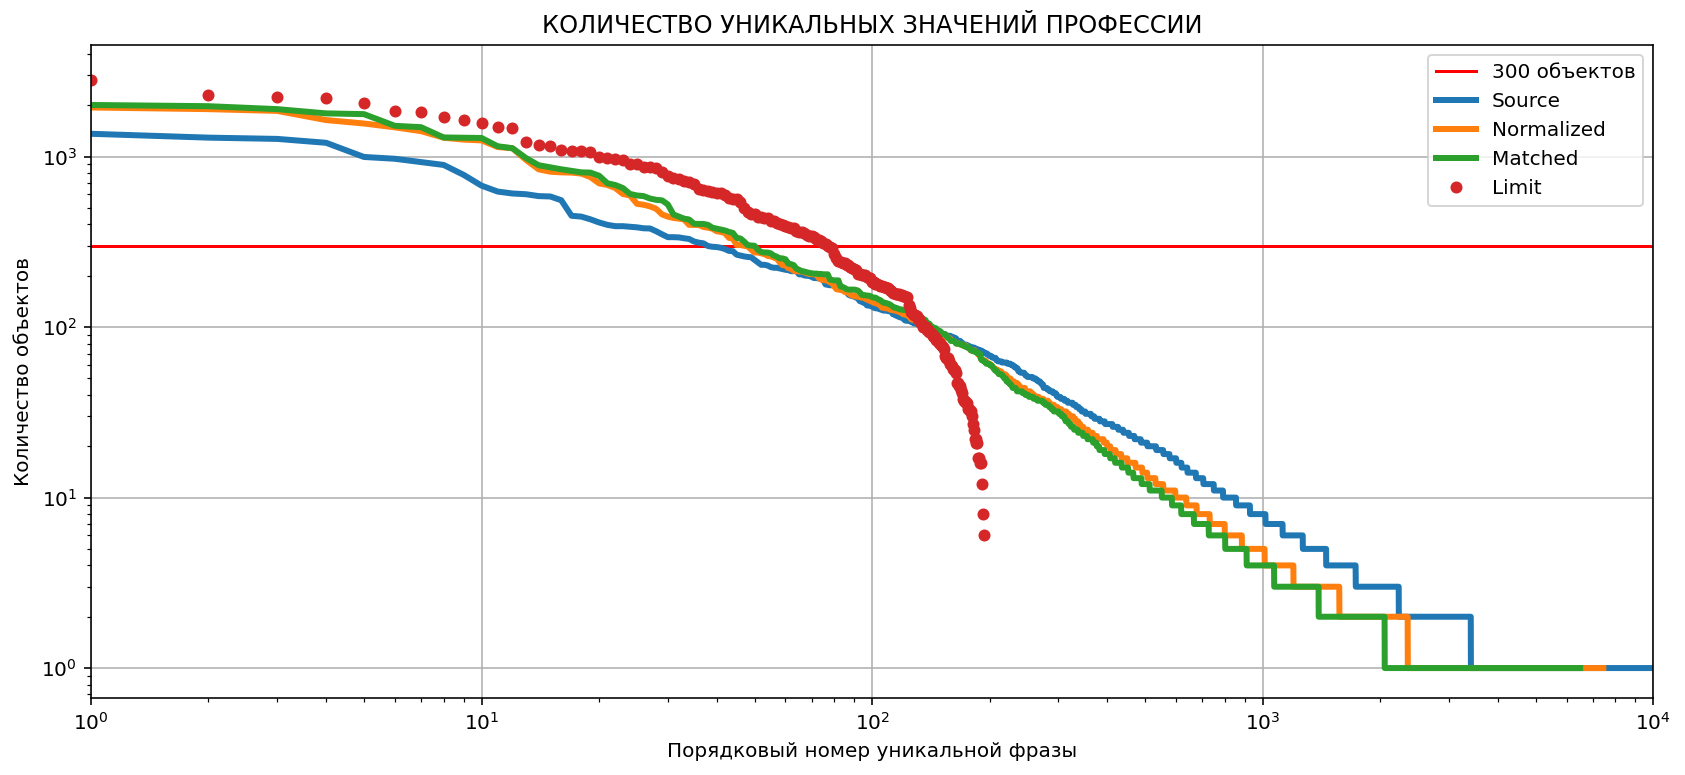

In [209]:
plt.figure(figsize=(14,6))
plt.yscale('log')
plt.xscale('log')
plt.axhline(300, c='r', label='300 объектов')
plt.plot(source_distribution.index, source_distribution['q61'], label='Source', lw=3)
plt.plot(normailized_ditribution.index, normailized_ditribution['normalized'], label='Normalized', lw=3)
plt.plot(matched_ditribution.index, matched_ditribution['matched_token'], label='Matched', lw=3)
plt.plot(limit.index, limit['matched_token'], label='Limit', lw=0, marker='o', markersize=5)
plt.ylabel('Количество объектов')
plt.xlabel('Порядковый номер уникальной фразы')
plt.title('Количество уникальных значений профессии'.upper())
plt.legend()
plt.grid(visible=True)
plt.xlim(1, 1e4)
plt.show()